In [0]:
import tensorflow as tf
from keras.datasets import mnist
import time
import matplotlib.pyplot as plt
from IPython import display
import os
from IPython.display import Image
import numpy as np

In [0]:
(xtrain, ytrain) , (xtest,ytest) = mnist.load_data()

In [25]:
print(xtrain.shape)
print(xtest.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
xtrain = xtrain.reshape(xtrain.shape[0], 28, 28, 1).astype('float32')
xtrain = (xtrain - 127.5) / 127.5

In [27]:
print(xtrain.shape)

(60000, 28, 28, 1)


In [0]:
batchSize = 256
parameterInsideAdam = 1e-4

In [0]:
trainSet = tf.data.Dataset.from_tensor_slices(xtrain)
trainSet = trainSet.shuffle(xtrain.shape[0])
trainSet = trainSet.batch(batchSize)

In [0]:
def ganGeneartor():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


In [0]:
generator = ganGeneartor()

In [0]:
def ganDiscriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [0]:
discriminator = ganDiscriminator()

In [0]:
def geneartorLoss(generatedOutput):
  # print("generator type: ",type(generatedOutput))
  generatorLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generatedOutput), generatedOutput)
  return generatorLoss

In [0]:
def discriminatorLoss(generatedOutput, realOutput):
  # print("generator type: ",type(generatedOutput))
  # print("discriminator type: ",type(generatedOutput))
  generatedOutputLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generatedOutput), generatedOutput)
  realOutputLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(realOutput), realOutput)
  return (generatedOutputLoss + realOutputLoss)

In [0]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
generator = ganGeneartor()
discriminator = ganDiscriminator()


In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# This annotation causes the function to be "compiled".
@tf.function
def trainInBatch(imageBatch):
  noise = tf.random.normal([batchSize, noise_dim])

  with tf.GradientTape() as generatorTape, tf.GradientTape() as discriminatorTape:
    geneartedImage = generator(noise,training = True)

    realOutput = discriminator(imageBatch,training =True)
    # print("realOutput:",realOutput)
    fakingOutput = discriminator(geneartedImage, training = True)
    # print("fakeOutput:",realOutput)
    generator_loss = geneartorLoss(fakingOutput)
    discriminator_loss = discriminatorLoss(fakingOutput, realOutput)
  
  generator_optimizer.apply_gradients(zip(generatorTape.gradient(generator_loss,generator.trainable_variables) , generator.trainable_variables )) #For Backpropagation
  discriminator_optimizer.apply_gradients(zip(discriminatorTape.gradient(discriminator_loss,discriminator.trainable_variables) , discriminator.trainable_variables )) #For Backpropagation
  

In [0]:
def generateAndSave(model, epoch, test_input):
  predictions = model(test_input,training = False)
  # generatedImage = np.asarray(predictions[0]*127.5 + 127.5)
  # print(generatedImage.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      generatedImage = tf.keras.preprocessing.image.array_to_img(predictions[i]*127.5 + 127.5, data_format=None, scale=True, dtype='float32')
      plt.imshow(np.asarray(generatedImage), cmap='gray')
      plt.axis('off')

  plt.savefig("image_at_epoch_"+ str(epoch)+".png")
  plt.show()

In [0]:
def train(data, epochs):

  # originalImage = tf.keras.preprocessing.image.array_to_img(xtrain[0], data_format=None, scale=True, dtype='float32')
  # plt.imshow(np.asarray(originalImage),cmap="gray")
  # plt.show()
  # originalImage.save("originalImage.png","PNG")
  # originalImageLocationString = tf.io.read_file("originalImage.png")
  # originalImage = tf.io.decode_png(originalImageLocationString)
  # # print(type(originalImage))

  for epoch in range(epochs):
    startTime  = time.time()

    for imageBatch in data:

      trainInBatch(imageBatch)
    # seed = tf.random.normal([num_examples_to_generate, noise_dim])

    # predictions = generator(seed,training = False)

    # generatedImage = tf.keras.preprocessing.image.array_to_img(predictions[0]*127.5 + 127.5, data_format=None, scale=True, dtype='float32')
    # plt.imshow(np.asarray(generatedImage),cmap="gray")
    # plt.show()
    # generatedImageLocation = "Epoch-"+str(epoch+1)+".png"
    # generatedImage.save(generatedImageLocation)
    
    # generatedImageLocationString = tf.io.read_file(generatedImageLocation)
    # generatedImage = tf.io.decode_png(generatedImageLocationString)
    # # print(type(generatedImage))

    # ssim = tf.image.ssim(originalImage, generatedImage, max_val=1.0, filter_size=4,
    #                       filter_sigma=1.5, k1=0.01, k2=0.03)
    
    
    
    # print("Epoch : ", epoch+1,",", " training time : ",time.time()-startTime, ",", "SSIM : ",ssim)
    # plt.imshow(xtrain[0].reshape(28,28),  cmap="gray")
    
    # os.remove(generatedImageLocation)

    # generated_image = generator(seed, training = False)
    # print("Discriminator Loss: ",discriminator(generated_image))
    # loss = discriminator(generated_image)
    print("Epoch : ", epoch+1,",", " training time : ",time.time()-startTime)
    # loss = "discriminator loss for 16 example are: " + str(tf.print(loss[0]))
    # print(loss)
  print("---------------------Generated Image-----------------------------------------")
  generateAndSave(generator,epochs,seed)
  print("---------------------Original Image-----------------------------------------")
  fig = plt.figure(figsize=(4,4))

  for i in range(16):
      plt.subplot(4, 4, i+1)
      originalImage = tf.keras.preprocessing.image.array_to_img(xtrain[i]*127.5 + 127.5, data_format=None, scale=True, dtype='float32')
      plt.imshow(np.asarray(originalImage), cmap='gray')
      plt.axis('off')
     
  plt.savefig("originalImage.png")
  plt.show()

  # generated_image = generator(seed, training = False)
  # print("Final Discriminator Loss for 16 Generated Image: ",discriminator(generated_image))
  
  


Epoch :  1 ,  training time :  12.238376140594482
Epoch :  2 ,  training time :  10.400644063949585
Epoch :  3 ,  training time :  10.52396821975708
Epoch :  4 ,  training time :  10.662012100219727
Epoch :  5 ,  training time :  10.79157042503357
Epoch :  6 ,  training time :  10.706889867782593
Epoch :  7 ,  training time :  10.615949630737305
Epoch :  8 ,  training time :  10.607760667800903
Epoch :  9 ,  training time :  10.539034843444824
Epoch :  10 ,  training time :  10.592292070388794
Epoch :  11 ,  training time :  10.573237419128418
Epoch :  12 ,  training time :  10.641231536865234
Epoch :  13 ,  training time :  10.611907005310059
Epoch :  14 ,  training time :  10.605278015136719
Epoch :  15 ,  training time :  10.592592716217041
Epoch :  16 ,  training time :  10.622884273529053
Epoch :  17 ,  training time :  10.575559616088867
Epoch :  18 ,  training time :  10.580503463745117
Epoch :  19 ,  training time :  10.56233549118042
Epoch :  20 ,  training time :  10.57774877

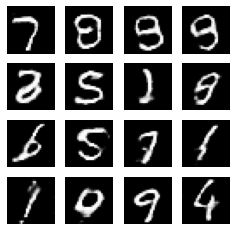

---------------------Original Image-----------------------------------------


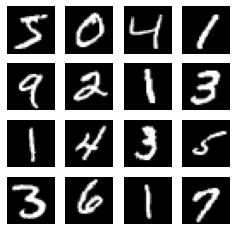

In [41]:
epochs = 100
train(trainSet,epochs)

In [0]:
from PIL import Image 
generatedImage = Image.open("generated.PNG")
generatedImage = generatedImage.resize((28,28))

originalImage = Image.open("original.PNG")
originalImage = originalImage.resize((28,28))

In [66]:
from skimage.metrics import structural_similarity as ssim
ssimValue , diff = ssim(np.asarray(originalImage), np.asarray(generatedImage),multichannel=True, full =True)
print("SSIMvalue: ",ssimValue)


SSIMvalue:  0.7425119375694649
